# Problem Statement

<b><li>Though, many of us don't appreciate much, but a farmer's job is real test of endurance and determination.</li></b>
<b><li>Once the seeds are sown, he works days and nights to make sure that he cultivates a good harvest at the end of season.</li></b>

<br>

<b><li>A good harvest is ensured by several factors such as availability of water, soil fertility, timely use of pesticides and nature.</li></b>
<b><li>While a lot of these factors are difficult to control for, the amount and frequency of pesticides is something the farmer can control.</li></b>
<b><li>Pesticides are also special, because they protect the crop with the right dosage.</li>
<b><li>But, if you add more than required, they may spoil the entire harvest.</li></b>
<b><li>A high level of pesticide can deem the crop dead / unsuitable for consumption among many outcomes.</li></b>

<br>
    
<b><li>This data is based on crops harvested by various farmers at the end of harvest season.</li></b>
<b><li>To simplify the problem, you can assume that all other factors like variations in farming techniques have been controlled for.</li></b>
<b><li>You need to datermine whether the crop would be healthy(alive), damaged by pesticides or damaged by other reasons.</li></b>

![](images/crop_health.png)

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import f_oneway
import plotly.graph_objects as go
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings('ignore')

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
print(train_df.shape)
print(test_df.shape)

(88858, 10)
(59310, 9)


In [5]:
combined_df = pd.concat([train_df, test_df], axis = 0)
print(combined_df.shape)

(148168, 10)


In [6]:
combined_df['ID'].value_counts()

F00000001    1
F00026237    1
F00026101    1
F00026102    1
F00026105    1
            ..
F00086672    1
F00086673    1
F00086674    1
F00086681    1
F00155944    1
Name: ID, Length: 148168, dtype: int64

In [7]:
combined_df.head()

ID  Estimated_Insects_Count  Crop_Type  Soil_Type  \
0  F00000001                      188          1          0   
1  F00000003                      209          1          0   
2  F00000004                      257          1          0   
3  F00000005                      257          1          1   
4  F00000006                      342          1          0   

   Pesticide_Use_Category  Number_Doses_Week  Number_Weeks_Used  \
0                       1                  0                0.0   
1                       1                  0                0.0   
2                       1                  0                0.0   
3                       1                  0                0.0   
4                       1                  0                0.0   

   Number_Weeks_Quit  Season  Crop_Damage  
0                  0       1          0.0  
1                  0       2          1.0  
2                  0       2          1.0  
3                  0       2          1.0  
4                  0       2          1.0

In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148168 entries, 0 to 59309
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       148168 non-null  object 
 1   Estimated_Insects_Count  148168 non-null  int64  
 2   Crop_Type                148168 non-null  int64  
 3   Soil_Type                148168 non-null  int64  
 4   Pesticide_Use_Category   148168 non-null  int64  
 5   Number_Doses_Week        148168 non-null  int64  
 6   Number_Weeks_Used        133275 non-null  float64
 7   Number_Weeks_Quit        148168 non-null  int64  
 8   Season                   148168 non-null  int64  
 9   Crop_Damage              88858 non-null   float64
dtypes: float64(2), int64(7), object(1)
memory usage: 12.4+ MB


In [9]:
combined_df.describe()

Estimated_Insects_Count      Crop_Type      Soil_Type  \
count            148168.000000  148168.000000  148168.000000   
mean               1398.212401       0.285453       0.457096   
std                 849.197419       0.451631       0.498158   
min                 150.000000       0.000000       0.000000   
25%                 731.000000       0.000000       0.000000   
50%                1212.000000       0.000000       0.000000   
75%                1898.000000       1.000000       1.000000   
max                4097.000000       1.000000       1.000000   

       Pesticide_Use_Category  Number_Doses_Week  Number_Weeks_Used  \
count           148168.000000      148168.000000      133275.000000   
mean                 2.263802          25.850724          28.656485   
std                  0.461755          15.525407          12.403662   
min                  1.000000           0.000000           0.000000   
25%                  2.000000          15.000000          20.000000   
50%                  2.000000          20.000000          28.000000   
75%                  3.000000          40.000000          37.000000   
max                  3.000000          95.000000          67.000000   

       Number_Weeks_Quit         Season   Crop_Damage  
count      148168.000000  148168.000000  88858.000000  
mean            9.565324       1.898527      0.190562  
std             9.882540       0.701568      0.454215  
min             0.000000       1.000000      0.000000  
25%             0.000000       1.000000      0.000000  
50%             7.000000       2.000000      0.000000  
75%            16.000000       2.000000      0.000000  
max            50.000000       3.000000      2.000000

### Missing Data Visualization

In [10]:
combined_df.isnull().sum()

ID                             0
Estimated_Insects_Count        0
Crop_Type                      0
Soil_Type                      0
Pesticide_Use_Category         0
Number_Doses_Week              0
Number_Weeks_Used          14893
Number_Weeks_Quit              0
Season                         0
Crop_Damage                59310
dtype: int64

<AxesSubplot:>

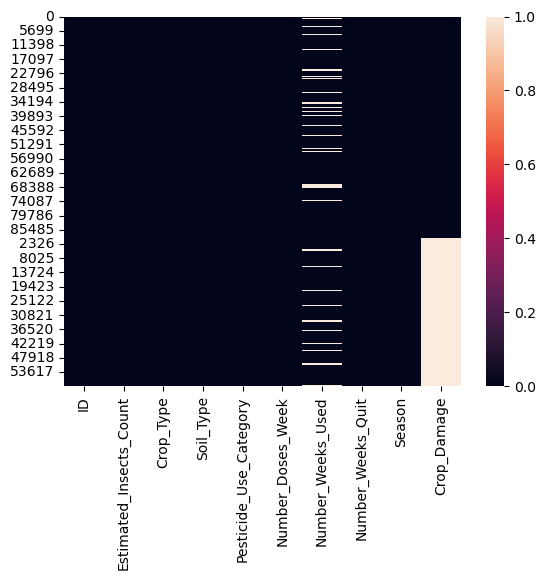

In [11]:
sns.heatmap(combined_df.isnull())

<li>From the given heatmap, we can see that there is missing value in 'Number_Weeks_Used' column.</li>

## EDA

In [12]:
def univariate_count(df, col, final_cols):
    
    df = df[col].value_counts().reset_index()
    df.columns = final_cols
    return df

In [13]:
def create_piechart(df, val_col, label_col, colors, title, explode):
    
    plt.figure(figsize = (8,6))
    plt.pie(df[val_col], labels = df[label_col], explode = explode,
           colors = colors, autopct = "%.2f")
    plt.legend(loc = "upper right", bbox_to_anchor = (1.3, 1))
    plt.title(title)
    plt.show()

In [14]:
def univariate_barplot(df, val_col, label_col, colors, title,
                       xlabel_title, ylabel_title):
    
    plt.figure(figsize = (8, 6))
    ax = sns.barplot(x = label_col, y = val_col, data = df, 
                     palette = colors, label = df[label_col])
    plt.legend()
    for value in ax.patches:
        ax.text(value.get_x(), value.get_height() + 5, value.get_height())
    plt.title(title)
    plt.xlabel(xlabel_title)
    plt.ylabel(ylabel_title)
    plt.show()
    


In [15]:
def univariate_numeric_plot(df, col_name, color):
    
    plt.figure(figsize = (20, 8))
    plt.subplot(1,3,1)
    sns.histplot(df[col_name], kde = True,
                 color = color,
                 alpha = 0.2,
                line_kws = {'linestyle': 'dashed'})
    plt.subplot(1,3,2)
    sns.kdeplot(df[col_name])
    plt.subplot(1,3,3)
    sns.boxplot(y = df[col_name])
    if shapiro(combined_df[col_name])[1] > 0.05:
        print("The data follows a normal distribution")
    else:
        print("The data does not follow a normal distribution")
    plt.show()
    
    

In [16]:
def bivariate_count(df, target_col, cause_col):
    
    bivariate_df = pd.crosstab(df[target_col], df[cause_col]).reset_index()
    bivariate_df = bivariate_df.rename_axis(None, axis = 1)
    return bivariate_df

In [17]:
def bivariate_vertical_layout(df, target_col, legend_x, legend_y, bar_width, bar_height):
    
    layout = go.Layout(
      legend=dict(
          x=legend_x,  
          y=legend_y),
      showlegend=True,
      font=dict(size=14),
      width=bar_width,
      height=bar_height,
      margin=dict(l=0, r=0, b=0, t=30),
    )
    return layout


In [18]:
def bivariate_horizontal_layout(df, target_col, legend_x, legend_y, bar_width, bar_height):
    
    layout = go.Layout(
      legend=dict(
          x=legend_x,  
          y=legend_y),
      showlegend=True,
      font=dict(size=14),
      width=bar_width,
      height=bar_height,
      margin=dict(l=0, r=0, b=0, t=30),
    )
    return layout

In [19]:
def create_bivariate_bargraph(df, colors, legend_labels,
                              target_col, graph_orientation, bar_width, bar_height,
                              legend_x, legend_y, fig_title, 
                              x_axis_title, y_axis_title):
    
    barplots = []
    columns = [col for col in list(df.columns) if col not in target_col]
    target_values = df[target_col]
    target_indexes = list(range(len(df)))
    if graph_orientation == "v":
        for i in range(len(columns)):
            barplots.append(go.Bar(x = target_values[target_indexes], 
            y = df[columns[i]], orientation = graph_orientation,
            name=legend_labels[i],
            text = df[columns[i]], 
            marker=go.bar.Marker(color=colors[i])))
        layout = bivariate_vertical_layout(df, target_col, legend_x, legend_y, bar_width, bar_height)    
    else:
        for i in range(len(columns)):
            barplots.append(go.Bar(x = df[columns[i]], 
            y = target_values[target_indexes], orientation = graph_orientation,
            name=legend_labels[i],
            text = df[columns[i]], 
            marker=go.bar.Marker(color=colors[i])))
    layout = bivariate_horizontal_layout(df, target_col, legend_x, legend_y, bar_width, bar_height)
    
# Make the multi-bar plot
    fig = go.Figure(data=barplots, layout=layout)
    fig.update_layout(title_text = fig_title)
    fig.update_xaxes(title_text=x_axis_title)
    fig.update_yaxes(title_text=y_axis_title)
    fig.show()

In [20]:
def bivariate_kdeplot(df, col_name, target_col, colors):
    
    target_values = list(df[target_col].unique())
    legends = []
    for index in range(len(target_values)):
        if type(target_values[index]).__name__ == 'float':
            legends.append('test')
            effect_col = df.loc[df[target_col].isnull()]
            sns.kdeplot(effect_col[col_name],
             color = colors[index])
        else: 
            legends.append(target_values[index])
            effect_df = df.loc[df[target_col] == target_values[index]]
            sns.kdeplot(effect_df[col_name],
                         color = colors[index])
    plt.legend(legends)
    
    

In [21]:
def bivariate_histplot(df, col_name, target_col, colors):
    
    target_values = list(df[target_col].unique())
    legends = []
    for index in range(len(target_values)):
        if type(target_values[index]).__name__ == 'float':
            legends.append('test')
            effect_col = df.loc[df[target_col].isnull()]
            sns.histplot(effect_col[col_name], kde = True,
             color = colors[index],
             alpha = 0.2,
            line_kws = {'linestyle': 'dashed'})
        else: 
            legends.append(target_values[index])
            effect_df = df.loc[df[target_col] == target_values[index]]
            sns.histplot(effect_df[col_name], kde = True,
                         color = colors[index],
                         alpha = 0.2,
                        line_kws = {'linestyle': 'dashed'})
    plt.legend(legends)
    
    

In [22]:
def bivariate_hist_kdeplot(df, col_name, target_col, colors):
    
    plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    bivariate_histplot(df, col_name, target_col, colors)
    plt.subplot(1,2, 2)
    bivariate_kdeplot(eda_df, col_name, target_col, colors)
    plt.show()
    
    

In [23]:
def chisquare_test(df, cause_col, effect_col):
    
    cause_effect_df = pd.crosstab(df[effect_col], df[cause_col])
    alpha = 0.05
    H0 = "H0: There is no relationship between {} and {}".format(cause_col, effect_col)
    H1 = "H1: There is a relationship between {} and {}".format(cause_col, effect_col)
    test_stats = stats.chi2_contingency(observed = cause_effect_df)
    p_value = test_stats[1]
    print("P value is {}".format(p_value))
    if p_value <= alpha:
        print(H1)
    else:
        print(H0)

In [24]:
def fstatistic_test(df, cause_col, effect_col):
    
    alpha = 0.05
    category_group_list = df.groupby(effect_col)[cause_col].apply(list)
    H0 = "H0: There is no relationship or correlation between {} and {}".format(cause_col, effect_col)
    H1 = "H1: There is a relationship or correlation between {} and {}".format(cause_col, effect_col)
    anova_results = f_oneway(*category_group_list)
    p_value = anova_results[1]
    print("P value is {}".format(p_value))
    if p_value <= alpha:
        print(H1)
    else:
        print(H0)

### Creating a copy of our dataset for doing EDA

In [25]:
eda_df = combined_df.copy()
eda_df.replace({"Crop_Damage" : {0: "Alive",
                                 1: "Damage Due To Other Causes",
                                 2: "Damage Due To Pesticides"},
                
               "Crop_Type" : {0: "Crop_Type_0",
                              1: "Crop_Type_1"},
                
                "Soil_Type" : {0: "Soil_Type_0",
                               1: "Soil_Type_1"},
                
                "Pesticide_Use_Category" : {1: "Never Used",
                                            2: "Previously Used",
                                            3: "Currently Using"},
                
                "Season" : {1: "Season_One",
                            2: "Season_Two",
                            3: "Season_Three"}
               }, inplace = True)


In [26]:
eda_df = eda_df.reset_index(drop = True)
eda_df.head()

ID  Estimated_Insects_Count    Crop_Type    Soil_Type  \
0  F00000001                      188  Crop_Type_1  Soil_Type_0   
1  F00000003                      209  Crop_Type_1  Soil_Type_0   
2  F00000004                      257  Crop_Type_1  Soil_Type_0   
3  F00000005                      257  Crop_Type_1  Soil_Type_1   
4  F00000006                      342  Crop_Type_1  Soil_Type_0   

  Pesticide_Use_Category  Number_Doses_Week  Number_Weeks_Used  \
0             Never Used                  0                0.0   
1             Never Used                  0                0.0   
2             Never Used                  0                0.0   
3             Never Used                  0                0.0   
4             Never Used                  0                0.0   

   Number_Weeks_Quit      Season                 Crop_Damage  
0                  0  Season_One                       Alive  
1                  0  Season_Two  Damage Due To Other Causes  
2                  0  Season_Two  Damage Due To Other Causes  
3                  0  Season_Two  Damage Due To Other Causes  
4                  0  Season_Two  Damage Due To Other Causes

### Visualizing Target Column

In [27]:
crop_health_df = univariate_count(eda_df, col = "Crop_Damage",
                               final_cols = ["Crop_Damage", "Frequency"])

crop_health_df.head()

Crop_Damage  Frequency
0                       Alive      74238
1  Damage Due To Other Causes      12307
2    Damage Due To Pesticides       2313

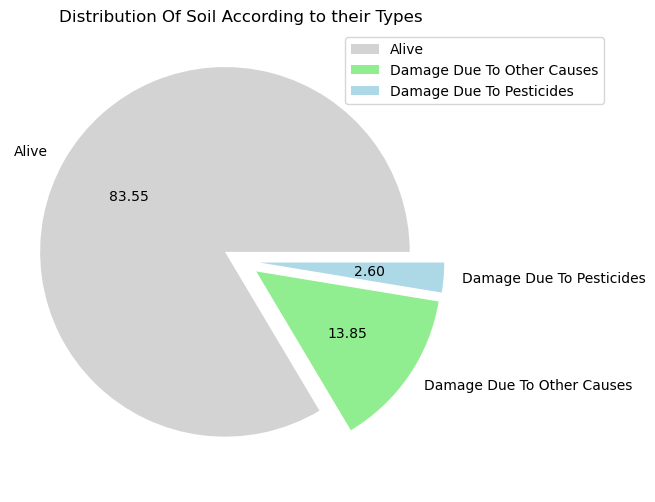

In [28]:
create_piechart(df = crop_health_df, val_col = "Frequency", 
                label_col = "Crop_Damage",
               colors = ['lightgray', 'lightgreen', 'lightblue'],
                explode = (0.1, 0.1, 0.1),
                title = "Distribution Of Soil According to their Types")

### Crop Type Distribution

In [29]:
crop_type_df = univariate_count(eda_df, col = "Crop_Type",
                               final_cols = ["Crop_Type", "Frequency"])


crop_type_df.head()

Crop_Type  Frequency
0  Crop_Type_0     105873
1  Crop_Type_1      42295

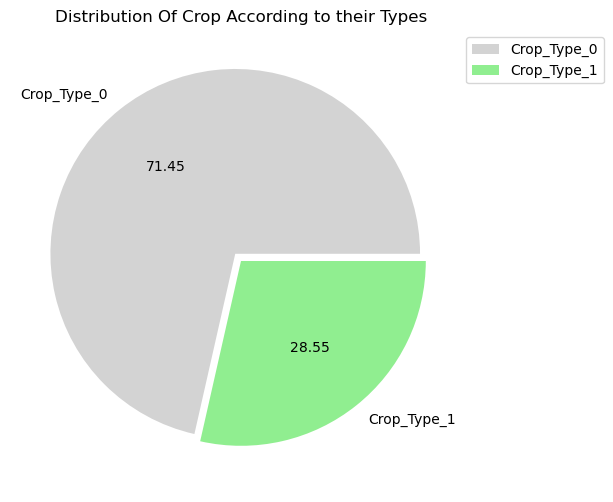

In [30]:
create_piechart(df = crop_type_df, val_col = "Frequency", 
                label_col = "Crop_Type",
                colors = ['lightgray', 'lightgreen'],
                explode = (0.05, 0),
                title = "Distribution Of Crop According to their Types")

<b><li>71.45% of crops belong to Type0_Crop.</li></b>
<b><li>Remaining 28.55% of crops belong to Type1_Crop.</li></b>

### Is Crop Heath determined by Crop Type?

In [31]:
crop_type_effect_df = bivariate_count(df = eda_df, 
                                      target_col = "Crop_Damage",
                                      cause_col = "Crop_Type")
crop_type_effect_df.head()

Crop_Damage  Crop_Type_0  Crop_Type_1
0                       Alive        52778        21460
1  Damage Due To Other Causes         9204         3103
2    Damage Due To Pesticides         1607          706

In [32]:
create_bivariate_bargraph(df = crop_type_effect_df, 
                          colors = ['red', 'blue'],
                          legend_labels = ['CropType0', 'CropType1'],
                          target_col = "Crop_Damage",
                          graph_orientation = "v",
                          bar_width = 800,
                          bar_height = 600,
                          legend_x = 0.839,
                          legend_y = 0.999,
                          fig_title = "Effect Of Crop Type On Crop Health", 
                          x_axis_title = "Crop Health",
                          y_axis_title = "Frequency")

<b><li>84.92% of type1 crop is alive.</li></b>
<b><li>82.99% of type0 crop is alive.</li></b>

<br>


<b><li>12.27% of type1 crop is damaged due to other causes.</li></b>
<b><li>14.47% of type0 crop is damaged due to other causes.</li></b>


<br>

<b><li>2.79% of type1 crop is damaged due to pesticides.</li></b>
<b><li>2.52% of type0 crop is damaged due to pesticides.</li></b>

### Testing Of Hypothesis: (Crop Health & Crop Type)

In [33]:
chisquare_test(df = eda_df, cause_col = "Crop_Type", effect_col = "Crop_Damage")

P value is 3.3787790720194964e-17
H1: There is a relationship between Crop_Type and Crop_Damage


<b><li>Since there is a relationship between crop health and crop type we can say that crop health is impacted by crop types.</li></b>

## Soil Type

In [34]:
soil_type_df = univariate_count(eda_df, col = "Soil_Type",
                               final_cols = ["Soil_Type", "Frequency"])

soil_type_df.head()

Soil_Type  Frequency
0  Soil_Type_0      80441
1  Soil_Type_1      67727

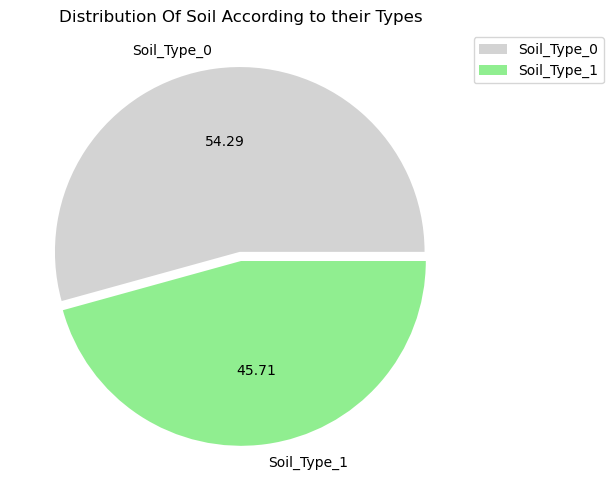

In [35]:
create_piechart(df = soil_type_df, val_col = "Frequency", 
                label_col = "Soil_Type",
               colors = ['lightgray', 'lightgreen'],explode = (0.05, 0),
                title = "Distribution Of Soil According to their Types")

<b><li>54.29% of crops are grown in Type0 Soil.</li></b>
<b><li>Remaining 45.71% of crops are grown in Type1 Soil.</li></b>

### Does the type of soil impact the health of crops?

In [36]:
soil_type_effect_df = bivariate_count(df = eda_df, 
                                      target_col = "Crop_Damage",
                                      cause_col = "Soil_Type")
soil_type_effect_df.head()

Crop_Damage  Soil_Type_0  Soil_Type_1
0                       Alive        39841        34397
1  Damage Due To Other Causes         6953         5354
2    Damage Due To Pesticides         1330          983

In [37]:
create_bivariate_bargraph(df = soil_type_effect_df, 
                          colors = ['red', 'blue'],
                          legend_labels = ['Soil_Type0', 'Soil_Type1'],
                          target_col = "Crop_Damage",
                          graph_orientation = "v",
                          bar_width = 800,
                          bar_height = 600,
                          legend_x = 0.8,
                          legend_y = 0.99,
                          fig_title = "Effect Of Soil Type On Crop Health", 
                          x_axis_title = "Crop Health",
                          y_axis_title = "Frequency")

<b><li>84.44% of type1 soil is alive.</li></b>
<b><li>82.78% of type0 soil is alive.</li></b>

<br>

<b><li>13.14% of type1 soil is damaged due to other causes.</li></b>
<b><li>14.44% of type0 soil is damaged due to other causes.</li></b>

<br>

<b><li>2.41% of type1 soil is damaged due to pesticides.</li></b>
<b><li>2.76% of type0 soil is damaged due to pesticides.</li></b>

### Test Of Hypothesis (Soil Type & Crop Damage)

In [38]:
chisquare_test(df = eda_df, cause_col = "Soil_Type", effect_col = "Crop_Damage")

P value is 1.9298029277753024e-10
H1: There is a relationship between Soil_Type and Crop_Damage


<b><li>Since there is a relationship between crop health and soil type we can say that crop health is impacted by soil types.</li></b>

<b><li>But when we see the impact of both crop types and soil types we can see the similar kinds of stats from bivariate analysis.</li></b>

<b><li>So, testing whether the two independent variables soil_type and crop_type have relationship between them or not.</li></b>

### Test Of Hypothesis (Soil Type & Crop Type)

In [39]:
chisquare_test(df = eda_df, cause_col = "Soil_Type", effect_col = "Crop_Type")

P value is 0.0
H1: There is a relationship between Soil_Type and Crop_Type


<b><li>We can see there is a relationship between soil_type and crop_types.</li></b>
<b><li>Since both are independent features so it will be difficult for the model to see how much impact each feature has on target.</li></b>
<b><li>So, while model building we can select any one of these features leaving one feature out.</li></b>

### Pesticide_Use_Category Column

In [40]:
pesticide_use_df = univariate_count(eda_df, col = "Pesticide_Use_Category",
                               final_cols = ["Pesticide_Use_Category", "Frequency"])
pesticide_use_df.head()

Pesticide_Use_Category  Frequency
0        Previously Used     106265
1        Currently Using      40495
2             Never Used       1408

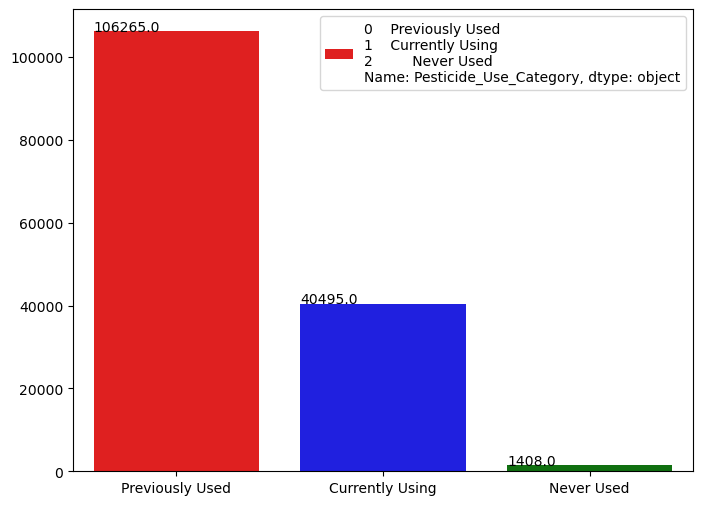

In [41]:
univariate_barplot(pesticide_use_df, val_col = "Frequency", 
                  label_col = "Pesticide_Use_Category", colors = ["red", "blue", "green"],
                  title = "", xlabel_title = "", ylabel_title = "")

<b><li>71.71% of crops have used the pesticides previously.</li></b>
<b><li>27.33% of crops are currently using the pesticides.</li></b>
<b><li>0.9% of crops are found not using the pesticides.</li></b>

In [42]:
pesticide_use_effect_df = bivariate_count(df = eda_df, 
                                      target_col = "Crop_Damage",
                                      cause_col = "Pesticide_Use_Category")
pesticide_use_effect_df.head()

Crop_Damage  Currently Using  Never Used  Previously Used
0                       Alive            17162         118            56958
1  Damage Due To Other Causes             5681         554             6072
2    Damage Due To Pesticides             1469         165              679

In [43]:
create_bivariate_bargraph(df = pesticide_use_effect_df, 
                          colors = ['red', 'blue', 'green'],
                          legend_labels = ['Currently Using', 'Never Used', 
                                          'Previously Used'],
                          target_col = "Crop_Damage",
                          graph_orientation = "v",
                          bar_width = 800,
                          bar_height = 600,
                          legend_x = 0.8,
                          legend_y = 0.99,
                          fig_title = "Effect Of Pesticide Use On Crop Health", 
                          x_axis_title = "Crop Health",
                          y_axis_title = "Frequency")

<b><li>89.4% of crops which have used pesticides previously are alive.</li></b>
<b><li>70.59% of crops which are currently using pesticides are alive.</li></b>
<b><li>Only 14.09% of crops which have never used pesticides are alive.</li></b>

<br>

<b><li>9.5% of crops which have used pesticides prevously are damaged due to other causes.</li></b>
<b><li>23.36% of crops which are currently using pesticides are damaged due to other causes.</li></b>
<b><li>66.18% of crops which have never used pesticides are damaged due to other causes.</li></b>

<br>

<b><li>Only 10.65% of crops which have used pesticides previously are damaged due to pesticides.</li></b>
<b><li>Only 6.04% of crops which are currenlty using pesticides are damaged due to pesticides.</li></b>
<b><li>19.71% of crops which have never used pesticides are damaged due to pesticides.</li></b>


<b><li>From this stats, we conclude that crops which had never used pesticides seems to get damaged due to other causes.</li></b>
<b><li>Similarly, the crops which are currently using pesticides are damaged due to pesticides due to overuse.</li></b>
<b><li>We can also see that crops which has never used pesticides are damaged due to pesticides. But How?.</li></b>

### Hypothesis Testing (Pesticide_Use_Category and Crop_Damage)

In [44]:
chisquare_test(df = eda_df, cause_col = "Pesticide_Use_Category", effect_col = "Crop_Damage")

P value is 0.0
H1: There is a relationship between Pesticide_Use_Category and Crop_Damage


### Season column

In [45]:
season_df = univariate_count(eda_df, col = "Season",
                               final_cols = ["Season", "Frequency"])
season_df.head()

Season  Frequency
0    Season_Two      73715
1    Season_One      44744
2  Season_Three      29709

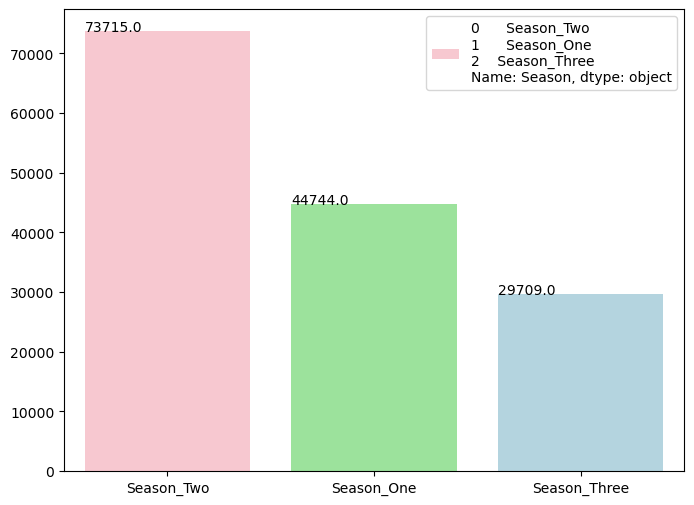

In [46]:
univariate_barplot(season_df, val_col = "Frequency", 
                  label_col = "Season", colors = ["pink", "lightgreen", "lightblue"],
                  title = "", xlabel_title = "", ylabel_title = "")

<b><li>49.75% of crops are grown in Season Two.</li></b>
<b><li>30.19% of crops are grown in Season One.</li></b>
<b><li>Only 20.05% of crops are grown in Season Three.</li></b>

In [47]:
season_effect_df = bivariate_count(df = eda_df, 
                                      target_col = "Crop_Damage",
                                      cause_col = "Season")
season_effect_df.head()

Crop_Damage  Season_One  Season_Three  Season_Two
0                       Alive       22493         14864       36881
1  Damage Due To Other Causes        3748          2444        6115
2    Damage Due To Pesticides         661           438        1214

In [48]:
create_bivariate_bargraph(df = season_effect_df, 
                          colors = ['red', 'blue', 'green'],
                          legend_labels = ['Season_1', 'Season_3', 
                                          'Season_2'],
                          target_col = "Crop_Damage",
                          graph_orientation = "v",
                          bar_width = 800,
                          bar_height = 600,
                          legend_x = 0.8,
                          legend_y = 0.99,
                          fig_title = "Effect Of Seasons On Crop Health", 
                          x_axis_title = "Crop Health",
                          y_axis_title = "Frequency")

<b><li>83.61% of crops grown in season one are alive.</li></b>
<b><li>83.75% of crops grown in season two are alive.</li></b>
<b><li>83.42% of crops grown in season three are alive.</li></b>

<br>

<b><li>13.93% of crops grown in season one are damaged due to other causes.</li></b>
<b><li>13.77% of crops grown in season two are damaged due to other causes.</li></b>
<b><li>13.83% of crops grown in season three are damaged due to other causes.</li></b>

<br> 

<b><li>2.45% of crops grown in season one are damaged due to pesticides.</li></b>
<b><li>2.46% of crops grown in season two are damaged due to pesticides.</li></b>
<b><li>2.75% of crops grown in season three are damaged due to pesticides.</li></b>

<b><li>The percentage of crop being damaged due to pesticides or any other causes is equal for any of the seasons.</li></b>
<b><li>Thus, we can say that season doesnot have any impact on the health of the crops.</li></b>
<b><li>Let's test the hypothesis to check whether there is a relationship between Season and Crop_Damage.</li></b>

In [49]:
chisquare_test(df = eda_df, cause_col = "Season", effect_col = "Crop_Damage")

P value is 0.11974800361205014
H0: There is no relationship between Season and Crop_Damage


<b><li>Since there is no relationship between season and crop damage we can say that crop health is not impacted by seasonality or seasons.</li></b>

### Estimated Insects Count

In [50]:
eda_df.describe()

Estimated_Insects_Count  Number_Doses_Week  Number_Weeks_Used  \
count            148168.000000      148168.000000      133275.000000   
mean               1398.212401          25.850724          28.656485   
std                 849.197419          15.525407          12.403662   
min                 150.000000           0.000000           0.000000   
25%                 731.000000          15.000000          20.000000   
50%                1212.000000          20.000000          28.000000   
75%                1898.000000          40.000000          37.000000   
max                4097.000000          95.000000          67.000000   

       Number_Weeks_Quit  
count      148168.000000  
mean            9.565324  
std             9.882540  
min             0.000000  
25%             0.000000  
50%             7.000000  
75%            16.000000  
max            50.000000

The data does not follow a normal distribution


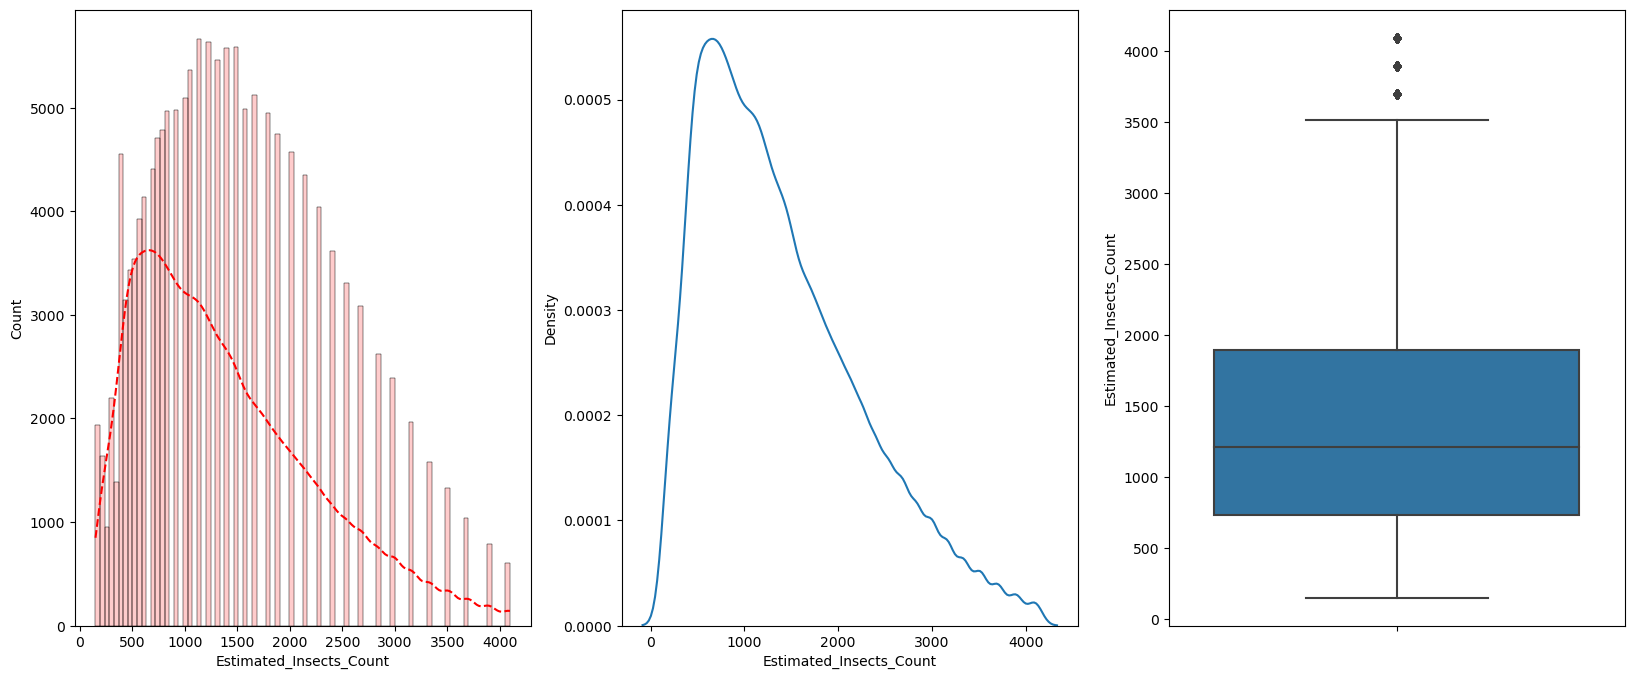

In [51]:
univariate_numeric_plot(df = eda_df, col_name = "Estimated_Insects_Count", color = "red")

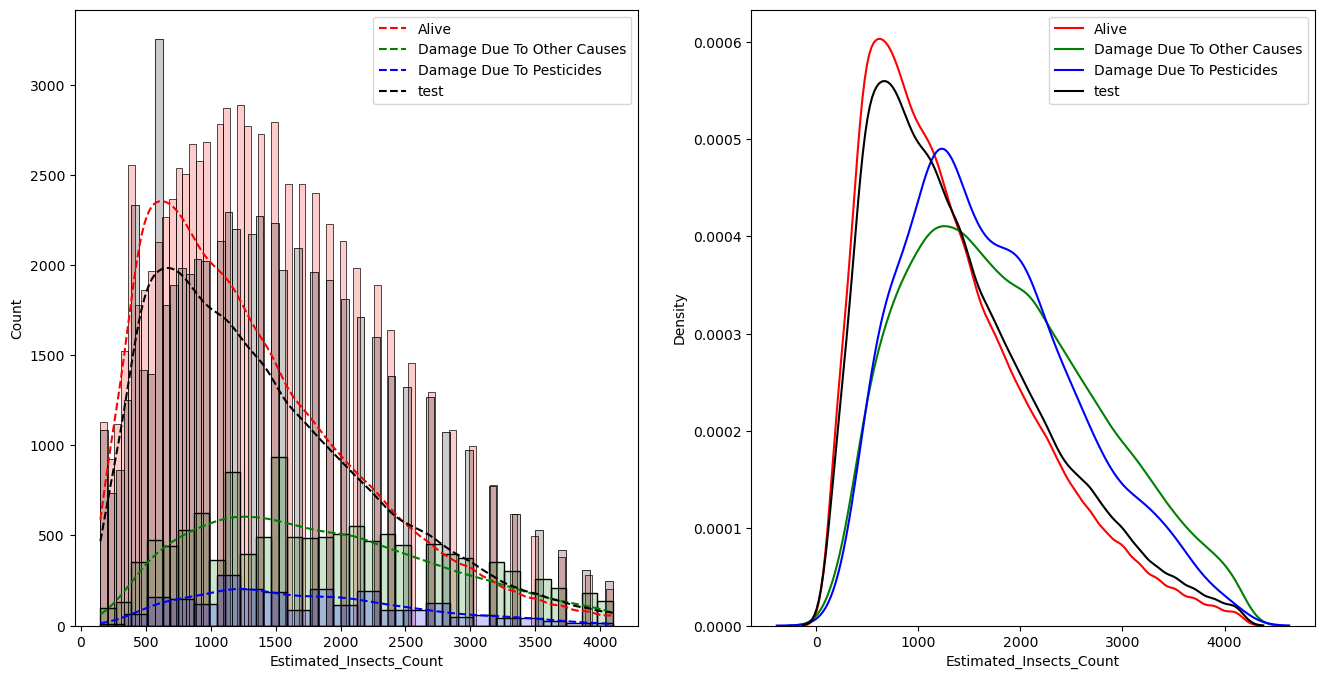

In [52]:
bivariate_hist_kdeplot(df = eda_df, col_name = "Estimated_Insects_Count",
                      target_col = "Crop_Damage", colors = ['red', 'green', 'blue', 'black'])

### Test Of Hypothesis (Crop_Damage & Estimated_Insects_Count

In [53]:
fstatistic_test(df = eda_df, cause_col = "Estimated_Insects_Count",
               effect_col = "Crop_Damage")

P value is 0.0
H1: There is a relationship or correlation between Estimated_Insects_Count and Crop_Damage


### Number_Doses_Week column

The data does not follow a normal distribution


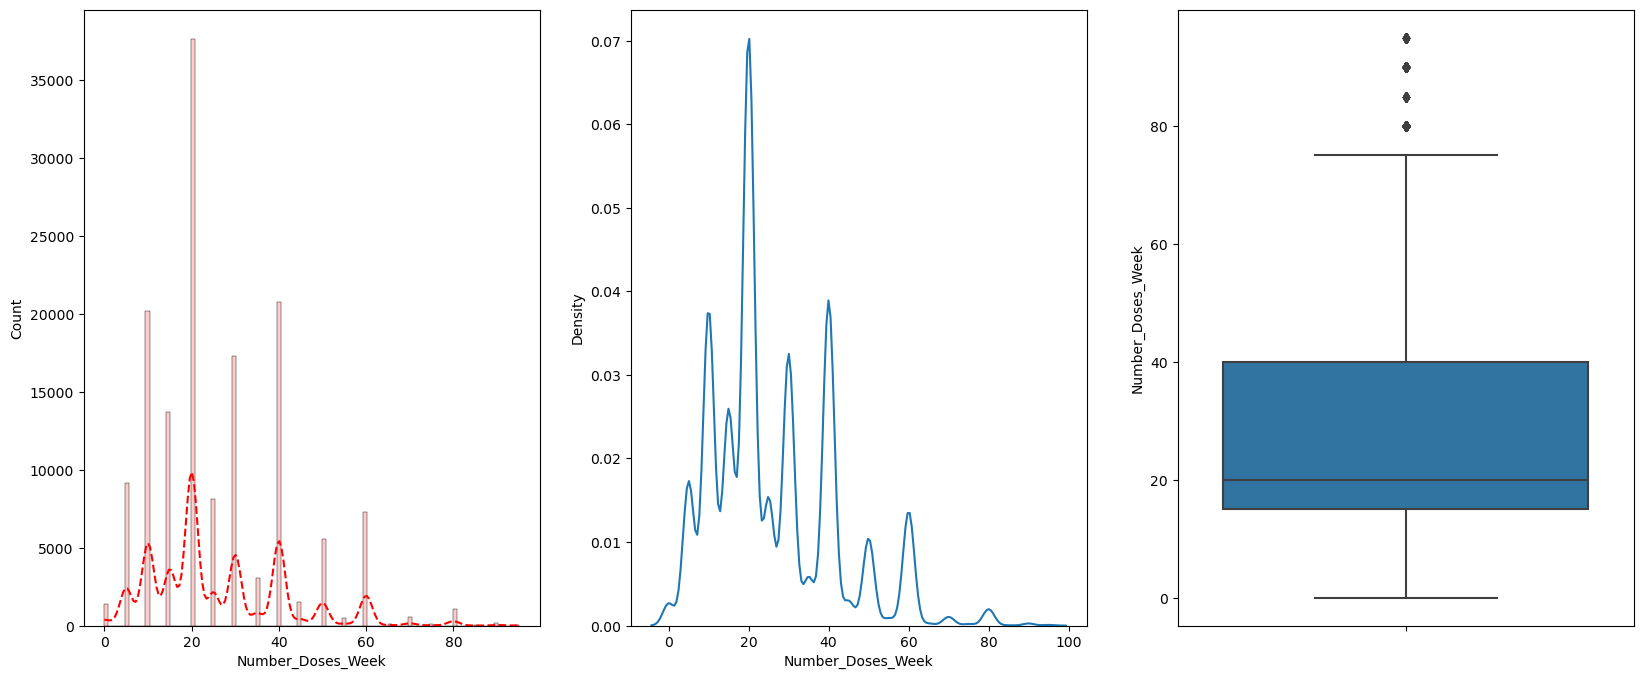

In [54]:
univariate_numeric_plot(df = eda_df, col_name = "Number_Doses_Week", color = "red")

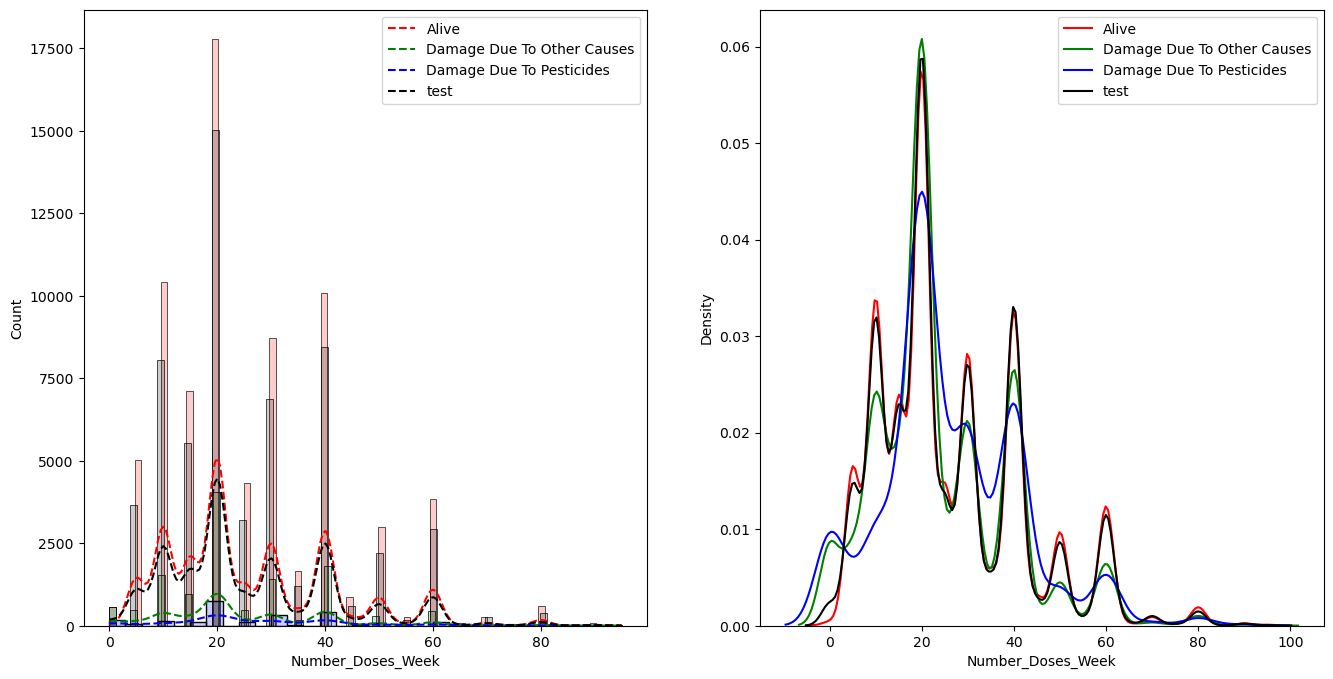

In [55]:
bivariate_hist_kdeplot(eda_df, col_name = "Number_Doses_Week",
                  target_col = 'Crop_Damage', colors = ['red', 'green', 'blue', 'black'])

### Hypothesis Testing (Number_Doses_Week & Crop_Damage)

In [56]:
fstatistic_test(df = eda_df, cause_col = "Number_Doses_Week",
               effect_col = "Crop_Damage")

P value is 1.1037968084421391e-36
H1: There is a relationship or correlation between Number_Doses_Week and Crop_Damage


### Number_of_weeks_used

The data follows a normal distribution


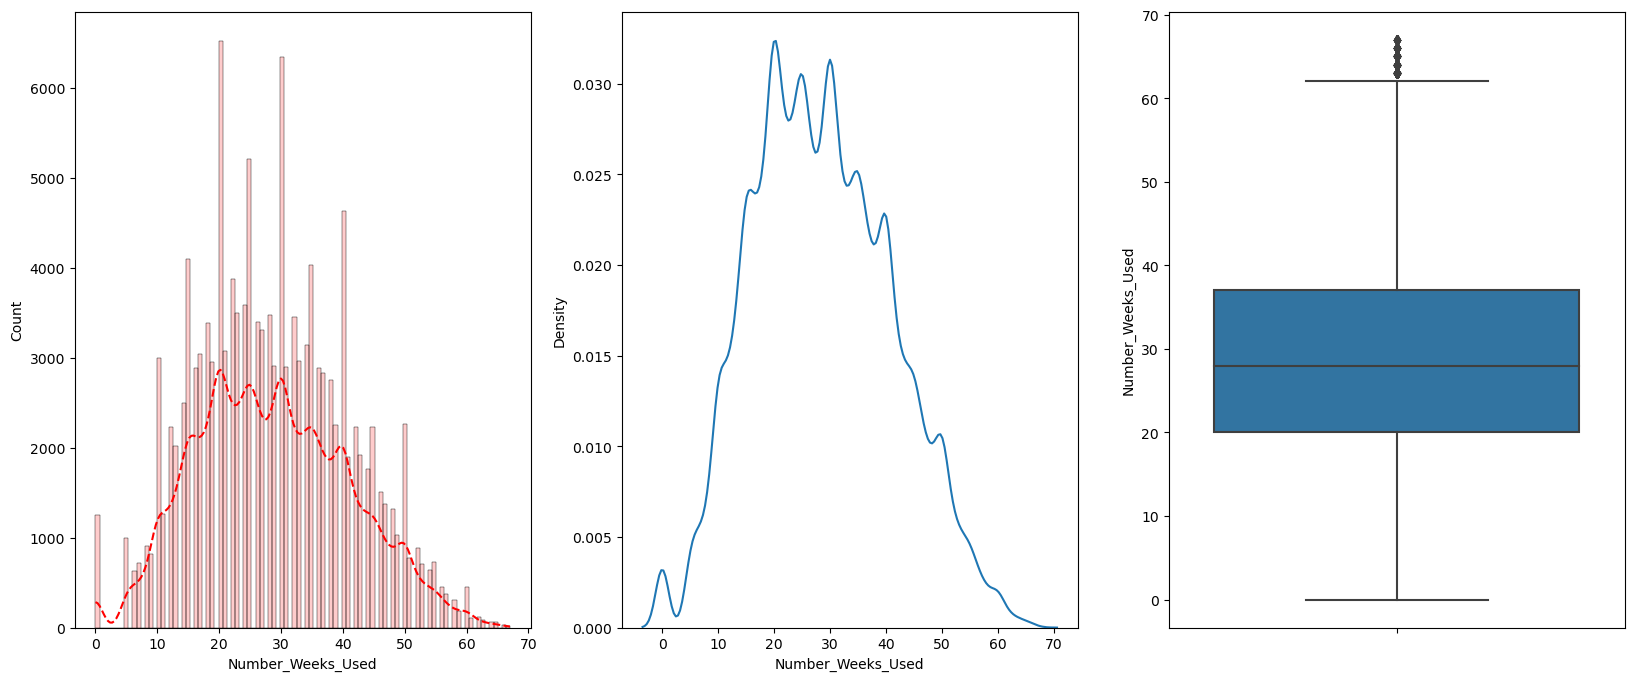

In [57]:
univariate_numeric_plot(df = eda_df, col_name = "Number_Weeks_Used", color = "red")

In [58]:
eda_df.loc[eda_df['Number_Weeks_Used']>56 , 'Crop_Damage'].value_counts()

Alive                         566
Damage Due To Other Causes    402
Damage Due To Pesticides       88
Name: Crop_Damage, dtype: int64

In [ ]:
bivariate_hist_kdeplot(eda_df, col_name = "Number_Weeks_Used",
                  target_col = 'Crop_Damage', colors = ['red', 'green', 'blue', 'black'])

In [ ]:
fstatistic_test(df = eda_df.dropna(), cause_col = "Number_Weeks_Used",
               effect_col = "Crop_Damage")

### Number_Weeks_Quit

In [ ]:
univariate_numeric_plot(df = eda_df, col_name = "Number_Weeks_Quit", color = "red")

In [ ]:
bivariate_hist_kdeplot(eda_df, col_name = "Number_Weeks_Quit",
                  target_col = 'Crop_Damage', colors = ['red', 'green', 'blue', 'black'])

In [ ]:
fstatistic_test(df = eda_df.dropna(), cause_col = "Number_Weeks_Quit",
               effect_col = "Crop_Damage")

In [ ]:
sns.heatmap(eda_df.corr(), annot = True)

In [ ]:
sns.scatterplot(data  = eda_df, x = 'Estimated_Insects_Count', y = 'Number_Doses_Week',
               hue = "Crop_Damage", palette = ['red', 'blue', 'green'])
plt.legend(loc = "upper right", bbox_to_anchor = (1.6, 1))
plt.show()

In [ ]:
sns.pairplot(eda_df, hue = "Crop_Damage")

### Modelling

In [ ]:
unnecessary_cols = ["ID", "Crop_Type", "Season"]
final_df = eda_df.drop(unnecessary_cols, axis = 1)
final_df.shape

#### Fill in missing values using mean

In [ ]:
final_df.isnull().sum()

In [ ]:
mean_fill = final_df['Number_Weeks_Used'].mean()

In [ ]:
final_df['Number_Weeks_Used'] = final_df['Number_Weeks_Used'].fillna(mean_fill)

In [ ]:
final_df.isnull().sum()

### Encoding Soil Type as binary output

In [ ]:
final_df.replace({"Soil_Type_0": 0, "Soil_Type_1":1}, inplace = True)

In [ ]:
final_df.head()

In [ ]:
pesticide_use_df = pd.get_dummies(final_df['Pesticide_Use_Category'])
pesticide_use_df.head()

In [ ]:
final_df = pd.concat([final_df, pesticide_use_df], axis = 1)
final_df.shape

In [ ]:
dummy_cols = ['Pesticide_Use_Category', 'Never Used']
final_df = final_df.drop(dummy_cols, axis = 1)
print(final_df.shape)

In [ ]:
final_df.head()

### Dataset Splitting(Train, Val, Test)

In [ ]:
train_df = final_df[~final_df['Crop_Damage'].isnull()]
test_df = final_df[final_df['Crop_Damage'].isnull()]
print("Shape of training dataset is {}".format(train_df.shape))
print("Shape of testing dataset is {}".format(test_df.shape))

In [ ]:
data = train_df.drop('Crop_Damage', axis =1)
labels = train_df['Crop_Damage']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2, random_state = 42)
x_test = test_df.drop('Crop_Damage', axis = 1)

In [ ]:
print("X_train Shape: {}".format(x_train.shape))
print("X_val Shape: {}".format(x_val.shape))
print("X_test Shape: {}".format(x_test.shape))

print("y_train Shape: {}".format(y_train.shape))
print("y_val Shape: {}".format(y_val.shape))


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
classifier = LogisticRegression()

In [ ]:
classifier.fit(x_train, y_train)

In [ ]:
y_pred = classifier.predict(x_val)

In [ ]:
print(y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

In [ ]:
confusion_matrix(y_val, y_pred)